<a href="https://colab.research.google.com/github/ebrasilio/dio_cienciadedados/blob/main/analise_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análises COVID-19
## Digital Innovation One 
### Prof. Dr. Neylson Crepalde
### por Emilia M S Brasilio
Apesar de usar o curso como base de aprendizado achei importante atualizar a base de dados, assim copiei dados, já consolidados para o Brasil até Nov/2022, no [tudo celular](https://www.tudocelular.com/tech/noticias/n154352/coronavirus-brasil-mundo-relatorio-covid-19.html), dados originais do site [Worldometers](https://www.worldometers.info/coronavirus/)

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Leitura e Organização dos Dados

In [7]:
# dados atualizados no Brasil
df = pd.read_csv('/content/drive/MyDrive/diome/covid_Brasil.csv') # , parse_dates=['Data']) não funcionou
df

,Data,Mortes,Casos
0,25/02/2020,0,1
1,26/02/2020,0,1
2,27/02/2020,0,1
3,28/02/2020,0,1
4,29/02/2020,0,2
...,...,...,...
985,06/11/2022,688348,34851450
986,07/11/2022,688395,34855492
987,08/11/2022,688487,34868153
988,09/11/2022,688567,34877559


In [8]:
df.Data = pd.to_datetime(df.Data, format='%d/%m/%Y')

In [9]:
df.dtypes

Data      datetime64[ns]
Mortes             int64
Casos              int64
dtype: object

In [10]:
# usando expressões regulares para limpar os nome:
import re    # regex 

def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [11]:
# for loop dentro de uma lista compreensiva
df.columns = [corrige_colunas(col) for col in df.columns]

In [12]:
px.line(df, x='data', y='mortes', title = 'Total Acumulado de Mortes - Brasil')

In [13]:
px.line(df, x='data', y='casos', title='Total Acumulado de Casos - Brasil')

In [14]:
# Novos casos por dia
# Técnica de programação funcional:

df['casosdia'] = list(map(                                                      #sapply
    lambda x: 0 if (x==0) else df['casos'].iloc[x] - df['casos'].iloc[x-1],     #função anônima
    np.arange(df.shape[0])
))

df['mortesdia'] = list(map(                                                      #sapply
    lambda x: 0 if (x==0) else df['mortes'].iloc[x] - df['mortes'].iloc[x-1],    #função anônima
    np.arange(df.shape[0])
))

In [15]:
# Plotar os dados diários:
fig  = go.Figure()
fig.add_trace(
    go.Scatter(x=df.data, y=df.mortesdia, name='Mortes', 
               mode='lines+markers', line={'color':'red'})
)

#layout
fig.update_layout(title='Mortes diarias por COVID-19 no Brasil')
fig.show()

In [16]:
# Plotar os dados diários:
fig  = go.Figure()
fig.add_trace(
    go.Scatter(x=df.data, y=df.casosdia, name='Casos Confirmados', 
               mode='lines+markers', line={'color':'red'})
)

#layout
fig.update_layout(title='Casos Diários de COVID-19 no Brasil')
fig.show()

In [17]:
df

,data,mortes,casos,casosdia,mortesdia
0,2020-02-25,0,1,0,0
1,2020-02-26,0,1,0,0
2,2020-02-27,0,1,0,0
3,2020-02-28,0,1,0,0
4,2020-02-29,0,2,1,0
...,...,...,...,...,...
985,2022-11-06,688348,34851450,1077,6
986,2022-11-07,688395,34855492,4042,47
987,2022-11-08,688487,34868153,12661,92
988,2022-11-09,688567,34877559,9406,80


## Função Taxa de Crescimento 
<p> tx = (presente/passado) ** (1/n) -1</p>

In [18]:
def taxa_crescimento(my_df, variable, data_inicio=None, data_fim=None):
    # se data = None pegar a disponivel
    if data_inicio == None:
        data_inicio = my_df.data.loc[my_df[variable] > 0 ].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    
    if data_fim == None:
        data_fim =  my_df.data.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)

    # selecionar o dado em questão
    passado =  my_df.loc[ my_df.data == data_inicio, variable].values[0]
    presente = my_df.loc[ my_df.data == data_fim, variable].values[0]

    # número de dias entre as datas
    n = (data_fim - data_inicio).days
    taxa = (presente / passado) ** (1/n) -  1
    return round(taxa * 100, 4)



In [19]:
taxa_crescimento(df, 'casos','2020-03-01', '2020-05-31')

14.6721

In [20]:
taxa_crescimento(df, 'casosdia','2022-11-01','2022-11-09')

1.5408

In [21]:
taxa_crescimento(df, 'mortesdia','2022-11-01','2022-11-09')


3.2375

In [22]:
def taxa_crescimento_diario(my_df, variable, data_inicio=None):
    # se data = None pegar a disponivel
    if data_inicio == None:
        data_inicio = my_df.data.loc[my_df[variable] > 0 ].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    
    data_fim = my_df.data.max()
    n = (data_fim - data_inicio).days
    # taxa calculada de um dia para o outro
    taxas = list( map(
        lambda x: (my_df[variable].iloc[x] - my_df[variable].loc[x-1]) / my_df[variable].iloc[x-1], range(1, n+1)   
    ))

    return np.array(taxas) * 100

In [23]:
tx =taxa_crescimento_diario(df, 'casos')

In [24]:
tx

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.00000000e+01,
        1.66666667e+02,  6.25000000e+01,  4.61538462e+01,  3.15789474e+01,
        0.00000000e+00,  3.60000000e+01,  5.29411765e+01,  4.80769231e+01,
        9.61038961e+01,  0.00000000e+00,  3.24503311e+01,  1.70000000e+01,
        4.78632479e+01,  5.28901734e+01,  2.09829868e+01,  5.15625000e+01,
        2.14432990e+01,  3.12393888e+01,  2.44501940e+01,  1.67879418e+01,
        1.36626613e+01,  1.68754894e+01,  1.44723618e+01,  1.42522681e+01,
        9.01639344e+00,  7.58928571e+00,  2.48525879e+01,  1.95732027e+01,
        1.57109421e+01,  1.44879899e+01,  1.34938163e+01,  8.28955050e+00,
        8.31985624e+00,  1.37773723e+01,  1.61113946e+01,  1.21177874e+01,
        9.97367979e+00,  5.54537122e+00,  6.95710908e+00,  5.68812305e+00,
        7.81903542e+00,  1.21051382e+01,  7.43290960e+00,  1.07050123e+01,
        8.66041209e+00,  

In [25]:
dia1 = df.data.loc[df.casos > 0].min()
px.line(x=pd.date_range(dia1, df.data.max())[1:], 
        y=tx, title='Taxa de Crescimento de Casos no Brasil')

<p></p>
<p><mark>28/01/2022</mark> - Início de venda de auto-testes sem qualquer obrigatoriedade de notificação, pesquisa por antígeno.</p>

# Predições

Primeiro é preciso entender alguns pontos sobre uma série temporal:
<ul><li>Tendencia</li><li>Sazonalidade</li><li> Ruido</li></ul>

Usando as funções <em>tsa (time series analisys</em> do statsmodel

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [27]:
confirmados = df.casos #brasil.novoscasos
confirmados.index = df.data #brasil.observationdate

res = seasonal_decompose(confirmados)  # decomposição dos dados

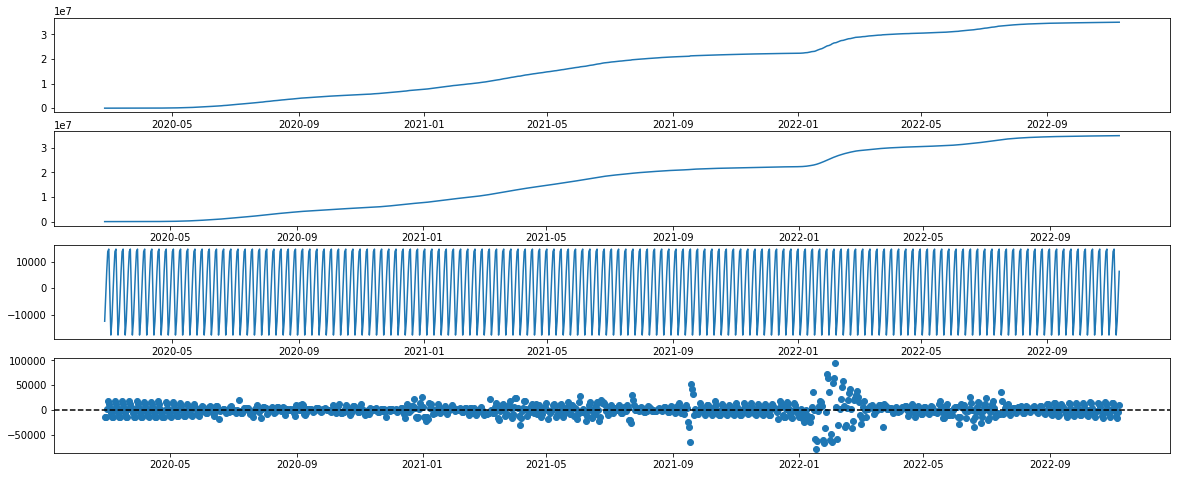

In [54]:
# 4 figuras em um painel, 4 linhas, uma columa
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(20,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

# Predizendo o número de casos confirmados com um AUTO-ARIMA

<p>Modelo linear simples, que não usa variáveis exógenas. Ele faz previsões baseadas apenas na própria série temporal.</p>
<p>Média móvel também é um modelo simples.</p>

In [28]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from pmdarima.arima import auto_arima

In [30]:
modelo = auto_arima(confirmados)

In [32]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observados'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predito-Aprendido'))
fig.add_trace(go.Scatter(x=pd.date_range('2022-11-22', '2023-11-21'), y=modelo.predict(365), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados no Brasil para o próximos mês',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

# Forecasting com Facebook Prophet

<p>Modelo de Crescimento.</p>

<p><mark>Nota de instalação:</mark> Como estamos no colab a instalção via conda não é possivel, logo recorri ao 

[stackoverflow](https://stackoverflow.com/questions/73142498/installing-fbprophet-on-colab)</p>



In [35]:
#!conda install -c conda-forge fbprophet -y
!pip install pystan~=2.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 107 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [36]:
!pip install fbprophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638815 sha256=3f762147d4afa718c32229b0059ac1aa4cfd3efb2f68830acf092fcb612bd8b7
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.


In [37]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.5 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.8 which is incompatible.


In [38]:
from fbprophet import Prophet

In [91]:
# preparando os dados
# a tabela df tem 990 entradas( 900 para treino e 9 para teste)
train = confirmados.reset_index()[:-150]
test = confirmados.reset_index()[-150:]

In [92]:
# renomeia colunas
train.rename(columns={"data":"ds","casos":"y"},inplace=True)
test.rename(columns={"data":"ds","casos":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

In [101]:
# modelo de crescimento - regressão logistica sigmoid - discordo desses changepoints
profeta = Prophet(growth="logistic", changepoints=['2020-05-10','2020-11-17','2021-08-16','2022-01-11','2022-03-09'])

In [102]:
# Cenário 1 - toda a população será contaminada
#pop = 1000000
pop = 215381512 # em 22/11/2022 https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

In [103]:
# Treina o modelo
profeta.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=150)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

In [105]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()